In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import os
from pathlib import Path

# ================================================
# 1) 데이터 로드
# ================================================

# 파일 찾기 - 여러 가능한 위치 확인
possible_paths = [
    r"C:\Users\starw\Downloads\Final Project_data.xlsb",
    r"C:\Users\starw\Downloads\Final Project_data.xlsx",
    r"C:\Users\starw\Downloads\Final Project_data.xls",
]

# Downloads 폴더에서 파일 검색
downloads_folder = Path.home() / "Downloads"
if downloads_folder.exists():
    print(f"Searching in: {downloads_folder}")
    excel_files = list(downloads_folder.glob("*Final*Project*.xl*"))
    if excel_files:
        print("\nFound Excel files:")
        for i, f in enumerate(excel_files, 1):
            print(f"  {i}. {f.name}")
        possible_paths.extend([str(f) for f in excel_files])

# 파일 찾기
file_path = None
for path in possible_paths:
    if os.path.exists(path):
        file_path = path
        print(f"\n✓ Found file: {file_path}")
        break

if file_path is None:
    print("\n❌ File not found. Please check:")
    print("   1. File name is correct")
    print("   2. File is in Downloads folder")
    print("   3. Update the path below manually:")
    print("\nManually set the path:")
    print('   file_path = r"YOUR_ACTUAL_FILE_PATH_HERE"')
    raise FileNotFoundError("Cannot find Final Project_data file")

# 파일 읽기
try:
    if file_path.endswith('.xlsb'):
        df_raw = pd.read_excel(file_path, engine="pyxlsb")
    else:
        df_raw = pd.read_excel(file_path)
except Exception as e:
    print(f"Error reading file: {e}")
    raise

# 2) 헤더 정리
cols_en = df_raw.iloc[1].tolist()
df = df_raw.iloc[3:].copy()
df.columns = cols_en

# 3) 날짜 인덱스
df["Year/Month"] = pd.to_datetime(df["Year/Month"], format="%Y.%m")
df = df.set_index("Year/Month")

# 4) 숫자형 변환
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")

print("\n완성된 shape:", df.shape)
print(df.head(3))

Searching in: C:\Users\starw\Downloads

Found Excel files:
  1. Final Project_data.xlsb

✓ Found file: C:\Users\starw\Downloads\Final Project_data.xlsb

완성된 shape: (300, 36)
            Building Electricity Consumption  \
Year/Month                                     
2000-01-01                          8676.229   
2000-02-01                          8785.390   
2000-03-01                          8477.618   

            Residential Electricity Consumption  \
Year/Month                                        
2000-01-01                             3065.085   
2000-02-01                             3191.737   
2000-03-01                             3054.528   

            Commercial + Public Electricity Consumption  \
Year/Month                                                
2000-01-01                                     5611.144   
2000-02-01                                     5593.653   
2000-03-01                                     5423.090   

            Number of Working Day

In [4]:
# ================================================
# Feature 생성 함수
# ================================================
def build_features(df, target_col, extra_features):
    
    df_ml = df.copy()

    # ---- 1) Lag features (Energies 논문 핵심) ----
    df_ml[f"{target_col}_lag1"] = df_ml[target_col].shift(1)
    df_ml[f"{target_col}_lag12"] = df_ml[target_col].shift(12)

    # ---- 2) 월 주기성 (ETFG 논문 핵심) ----
    df_ml["month"] = df_ml.index.month
    df_ml["month_sin"] = np.sin(2 * np.pi * df_ml["month"] / 12)
    df_ml["month_cos"] = np.cos(2 * np.pi * df_ml["month"] / 12)

    # ---- 3) Extra feature 존재 여부 확인 ----
    final_extra = [c for c in extra_features if c in df_ml.columns]

    feature_cols = [
        f"{target_col}_lag1",
        f"{target_col}_lag12",
        "month_sin",
        "month_cos",
    ] + final_extra
    
    # ---- 4) 결측 제거 ----
    df_ml = df_ml.dropna(subset=[target_col] + feature_cols)

    return df_ml, feature_cols


In [7]:
# ================================================
# XGBoost 학습 + 예측 함수
# ================================================
def fit_xgb(df_ml, target_col, feature_cols):
    
    # 인덱스 정렬 (DatetimeIndex가 monotonic해야 함)
    df_ml = df_ml.sort_index()
    
    # 날짜 범위 확인 및 조정
    print(f"Data range: {df_ml.index.min()} to {df_ml.index.max()}")
    
    # 실제 데이터 범위에 맞춰 train/test split
    # 2024년이 없으면 마지막 12개월을 테스트로 사용
    if df_ml.index.max().year >= 2024:
        train = df_ml[df_ml.index < "2024-01-01"]
        test = df_ml[df_ml.index >= "2024-01-01"]
    else:
        # 마지막 12개월을 테스트로
        split_point = len(df_ml) - 12
        train = df_ml.iloc[:split_point]
        test = df_ml.iloc[split_point:]
    
    print(f"Train: {train.index.min()} to {train.index.max()} ({len(train)} samples)")
    print(f"Test:  {test.index.min()} to {test.index.max()} ({len(test)} samples)")

    X_train, y_train = train[feature_cols], train[target_col]
    X_test, y_test   = test[feature_cols], test[target_col]

    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 성능 지표
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred)/y_test)) * 100

    result = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})

    return model, result, {"RMSE": rmse, "MAE": mae, "MAPE": mape}

In [8]:
res_target = "Residential Electricity Consumption"

res_features = [
    "Number of Working Days",
    "Number of Holidays",
    "Consumer Price Index – Total",
    "Consumer Sentiment Index",
    "Electricity price – Residential Tier 2",
    "National Average Temperature",
    "National Average Humidity",
    "National Average Daily Precipitation",
    "Cooling Degree Days (24°C)",
    "Heating Degree Days (18°C)",
    "Number of Heatwave Days (National)",
    "Number of Tropical Night Days (National)",
    "Number of Cold Spell Days (National)"
]

# Step 1: Build features
df_res_ml, res_feature_cols = build_features(df, res_target, res_features)

# Step 2: Train model and get results (THIS WAS MISSING!)
res_model, res_result, res_metrics = fit_xgb(df_res_ml, res_target, res_feature_cols)

# Step 3: Print results (NOW this will work)
print("\n📌 Residential 예측 성능:", res_metrics)
print(res_result)

Data range: 2010-01-01 00:00:00 to 2024-12-01 00:00:00
Train: 2010-01-01 00:00:00 to 2023-12-01 00:00:00 (168 samples)
Test:  2024-01-01 00:00:00 to 2024-12-01 00:00:00 (12 samples)

📌 Residential 예측 성능: {'RMSE': np.float64(833.0325822034674), 'MAE': 556.0122679036458, 'MAPE': np.float64(6.832106503377078)}
               Actual    Predicted
Year/Month                        
2024-01-01   6933.609  6157.469727
2024-01-01   6984.837  7422.203125
2024-02-01   6867.134  6861.093750
2024-03-01   6200.284  5972.768555
2024-04-01   6129.916  5954.947266
2024-05-01   5704.121  5932.325684
2024-06-01   6044.247  5971.341797
2024-07-01   7272.650  8101.190918
2024-08-01  10078.980  8016.611328
2024-09-01   9714.998  8164.325195
2024-11-01   6073.131  5952.174316
2024-12-01   6422.889  6609.357422


In [9]:
com_target = "Commercial + Public Electricity Consumption"

com_features = [
    "Number of Working Days",
    "Number of Holidays",
    "Consumer Price Index – Total",
    "Consumer Sentiment Index",
    "Electricity price  – General",
    "Service Industry Activity Index – Total",
    "National Average Temperature",
    "National Average Humidity",
    "National Average Daily Precipitation",
    "Cooling Degree Days (24°C)",
    "Heating Degree Days (18°C)",
    "Number of Heatwave Days (National)",
    "Number of Tropical Night Days (National)",
    "Number of Cold Spell Days (National)"
]

df_com_ml, com_feature_cols = build_features(df, com_target, com_features)

com_model, com_result, com_metrics = fit_xgb(df_com_ml, com_target, com_feature_cols)

print("\n📌 Commercial + Public 예측 성능:", com_metrics)
print(com_result)


Data range: 2001-01-01 00:00:00 to 2024-12-01 00:00:00
Train: 2001-01-01 00:00:00 to 2023-12-01 00:00:00 (276 samples)
Test:  2024-01-01 00:00:00 to 2024-12-01 00:00:00 (12 samples)

📌 Commercial + Public 예측 성능: {'RMSE': np.float64(463.8506942095831), 'MAE': 361.4658020833329, 'MAPE': np.float64(2.2988509626045586)}
               Actual     Predicted
Year/Month                         
2024-01-01  13854.046  13659.666016
2024-01-01  17632.795  16862.574219
2024-02-01  16650.078  16731.845703
2024-03-01  14940.156  14241.362305
2024-04-01  13693.235  13406.482422
2024-05-01  12712.268  12845.124023
2024-06-01  13872.111  13714.655273
2024-07-01  15659.069  15584.911133
2024-08-01  17668.490  16710.791016
2024-09-01  16897.780  16395.023438
2024-11-01  13323.245  13705.370117
2024-12-01  15530.392  15629.016602


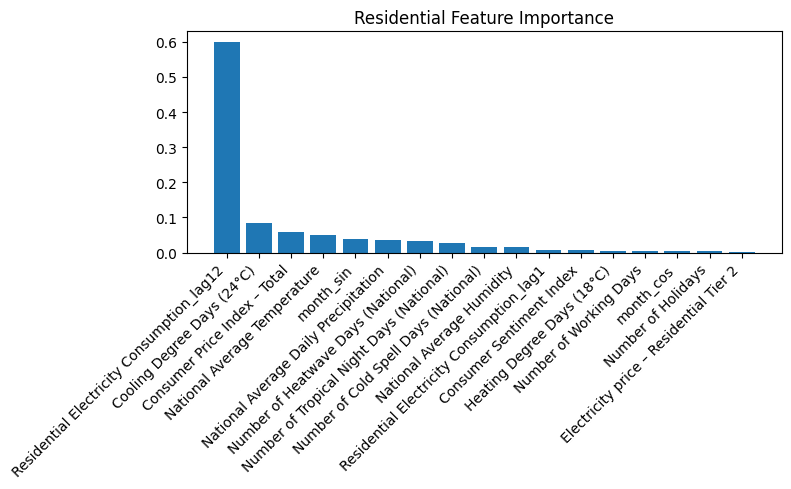

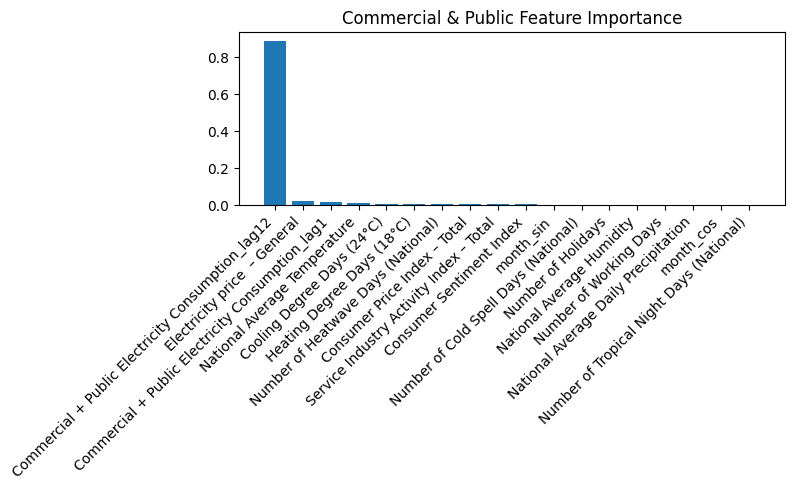

In [10]:
def plot_importance(model, feature_cols, title):
    imp = model.feature_importances_
    idx = np.argsort(imp)[::-1]

    plt.figure(figsize=(8,5))
    plt.bar(np.arange(len(idx)), imp[idx])
    plt.xticks(np.arange(len(idx)), [feature_cols[i] for i in idx], rotation=45, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_importance(res_model, res_feature_cols, "Residential Feature Importance")
plot_importance(com_model, com_feature_cols, "Commercial & Public Feature Importance")


In [12]:
# ================================================
# Log-Transformed XGBoost Model
# ================================================
def fit_xgb_log(df_ml, target_col, feature_cols):
    """
    Train XGBoost using log-transformed target variable.
    
    Steps:
    1. Transform target: y_log = log(y)
    2. Train model on y_log
    3. Back-transform predictions: y_pred = exp(y_pred_log)
    4. Compute metrics on original scale
    """
    
    # 인덱스 정렬 (DatetimeIndex가 monotonic해야 함)
    df_ml = df_ml.sort_index()
    
    # 날짜 범위 확인 및 조정
    print(f"Data range: {df_ml.index.min()} to {df_ml.index.max()}")
    
    # 실제 데이터 범위에 맞춰 train/test split
    # 2024년이 없으면 마지막 12개월을 테스트로 사용
    if df_ml.index.max().year >= 2024:
        train = df_ml[df_ml.index < "2024-01-01"]
        test = df_ml[df_ml.index >= "2024-01-01"]
    else:
        # 마지막 12개월을 테스트로
        split_point = len(df_ml) - 12
        train = df_ml.iloc[:split_point]
        test = df_ml.iloc[split_point:]
    
    print(f"Train: {train.index.min()} to {train.index.max()} ({len(train)} samples)")
    print(f"Test:  {test.index.min()} to {test.index.max()} ({len(test)} samples)")

    X_train, y_train = train[feature_cols], train[target_col]
    X_test, y_test   = test[feature_cols], test[target_col]
    
    # ---- 1) Log-transform the target ----
    y_train_log = np.log(y_train)
    y_test_log = np.log(y_test)
    
    # ---- 2) Train XGBoost on log-transformed target ----
    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train, y_train_log)
    
    # ---- 3) Predict in log-space and back-transform ----
    y_pred_log = model.predict(X_test)
    y_pred = np.exp(y_pred_log)  # Back-transform to original scale
    
    # ---- 4) Compute metrics on original scale ----
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred)/y_test)) * 100
    
    result = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
    
    return model, result, {"RMSE": rmse, "MAE": mae, "MAPE": mape}


# ================================================
# Apply Log-Transformation to Both Models
# ================================================

print("=" * 60)
print("🔄 LOG-TRANSFORMED MODEL RESULTS")
print("=" * 60)

# --- Residential with Log-Transform ---
res_model_log, res_result_log, res_metrics_log = fit_xgb_log(
    df_res_ml, res_target, res_feature_cols
)

print("\n📌 Residential (Log-Transformed):", res_metrics_log)
print("📌 Residential (Original):      ", res_metrics)
print(f"\n   MAPE Improvement: {res_metrics['MAPE'] - res_metrics_log['MAPE']:.2f}%")
print(f"   RMSE Improvement: {res_metrics['RMSE'] - res_metrics_log['RMSE']:.2f}")

# --- Commercial + Public with Log-Transform ---
com_model_log, com_result_log, com_metrics_log = fit_xgb_log(
    df_com_ml, com_target, com_feature_cols
)

print("\n📌 Commercial + Public (Log-Transformed):", com_metrics_log)
print("📌 Commercial + Public (Original):      ", com_metrics)
print(f"\n   MAPE Improvement: {com_metrics['MAPE'] - com_metrics_log['MAPE']:.2f}%")
print(f"   RMSE Improvement: {com_metrics['RMSE'] - com_metrics_log['RMSE']:.2f}")

print("\n" + "=" * 60)

# ================================================
# Display Prediction Comparison
# ================================================
print("\n📊 Residential Predictions Comparison (2024):")
comparison_res = pd.DataFrame({
    "Actual": res_result["Actual"],
    "Original_Model": res_result["Predicted"],
    "Log_Model": res_result_log["Predicted"]
})
print(comparison_res.round(2))

print("\n📊 Commercial + Public Predictions Comparison (2024):")
comparison_com = pd.DataFrame({
    "Actual": com_result["Actual"],
    "Original_Model": com_result["Predicted"],
    "Log_Model": com_result_log["Predicted"]
})
print(comparison_com.round(2))

🔄 LOG-TRANSFORMED MODEL RESULTS
Data range: 2010-01-01 00:00:00 to 2024-12-01 00:00:00
Train: 2010-01-01 00:00:00 to 2023-12-01 00:00:00 (168 samples)
Test:  2024-01-01 00:00:00 to 2024-12-01 00:00:00 (12 samples)

📌 Residential (Log-Transformed): {'RMSE': np.float64(776.5755366234713), 'MAE': 513.5969033203124, 'MAPE': np.float64(6.310961488656012)}
📌 Residential (Original):       {'RMSE': np.float64(833.0325822034674), 'MAE': 556.0122679036458, 'MAPE': np.float64(6.832106503377078)}

   MAPE Improvement: 0.52%
   RMSE Improvement: 56.46
Data range: 2001-01-01 00:00:00 to 2024-12-01 00:00:00
Train: 2001-01-01 00:00:00 to 2023-12-01 00:00:00 (276 samples)
Test:  2024-01-01 00:00:00 to 2024-12-01 00:00:00 (12 samples)

📌 Commercial + Public (Log-Transformed): {'RMSE': np.float64(541.4187773775334), 'MAE': 423.26371419270816, 'MAPE': np.float64(2.6858496368282787)}
📌 Commercial + Public (Original):       {'RMSE': np.float64(463.8506942095831), 'MAE': 361.4658020833329, 'MAPE': np.float64